In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
from functions.functions import *

CUDA is available. Using GPU.


In [2]:
def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1 / rmse)
    return rmse.item(), psnr.item()

In [3]:
def normalize(img):
    return img / 255.0

def denormalize(img):
    return img * 255.0

In [4]:
%%capture
img = torchvision.io.read_image("ES335-MLAssignment2/images t4/cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)

In [5]:
crop1 = torchvision.transforms.functional.crop(img, 50, 230, 300, 300)

In [6]:
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape[1:]) < prop
    mask_rgb = mask.unsqueeze(0).repeat(img.shape[0], 1, 1)
    img_copy[mask_rgb] = float('nan')
    
    return img_copy, mask_rgb

In [7]:
masked_img = mask_image(crop1, 0.01)

In [8]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return W, H, loss

In [9]:
W_red, H_red, loss_red = factorize(masked_img[0][0], 50)
W_green, H_green, loss_green = factorize(masked_img[0][1], 50)
W_blue, H_blue, loss_blue = factorize(masked_img[0][2], 50)

In [10]:
red_reconstructed = torch.mm(W_red, H_red)
green_reconstructed = torch.mm(W_green, H_green)
blue_reconstructed = torch.mm(W_blue, H_blue)
reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
reconstructed_img = reconstructed_img.to(torch.uint8)


In [11]:
def plot_images(original, masked, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_60057/348676207.py:6: RuntimeWarning: invalid value encountered in cast
  axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))


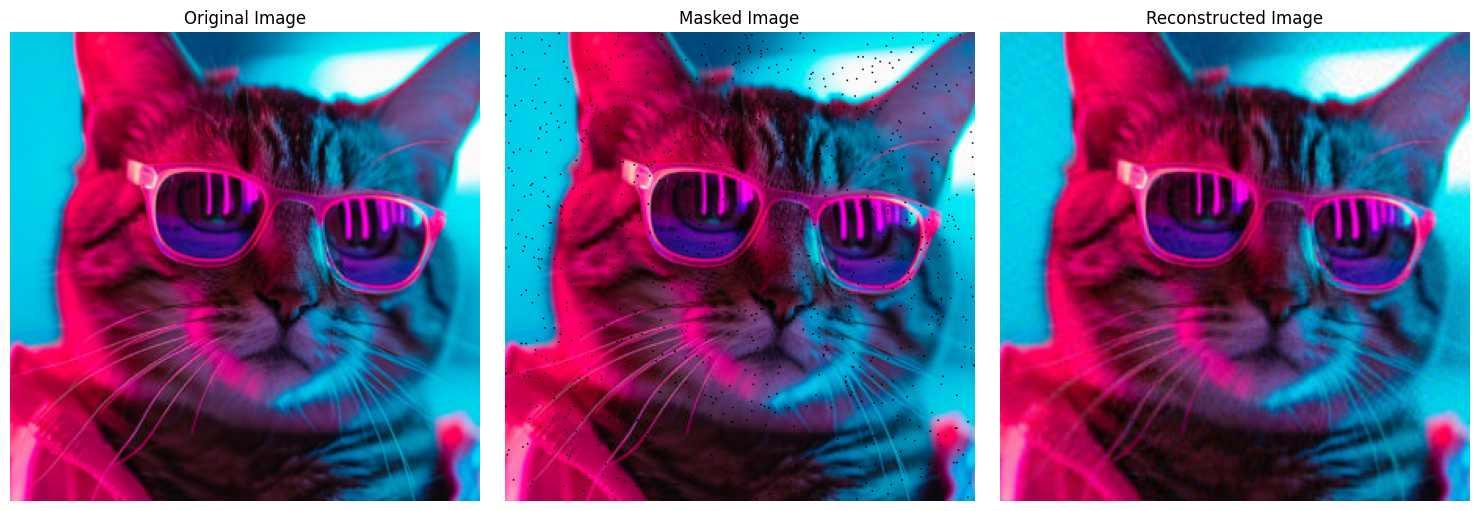

In [12]:
plot_images(crop1, masked_img[0], reconstructed_img)

In [28]:
rmse_rand_removed , psnr_rand_removed = calculate_metrics(normalize(crop1),normalize(reconstructed_img))

print("The Peak signal to noise ratio is:", psnr_rand_removed)
print("The Root mean square error is:", rmse_rand_removed)

The Peak signal to noise ratio is: 31.40740203857422
The Root mean square error is: 0.026892419904470444


**PART 2**

In [14]:
%%capture
img2 = torchvision.io.read_image("ES335-MLAssignment2/images t4/cyber-kitty.jpg")
img2 = torch.tensor(img2, dtype=torch.float)
crop2 = torchvision.transforms.functional.crop(img2, 50, 230, 300, 300)

In [15]:
def mask_block_image(img, block_size, num_blocks):
    img_copy = img.clone()
    h, w = img.shape[1], img.shape[2]
    assert block_size ** 2 <= img.numel() / 3, "Not enough pixels to place the block"
    for _ in range(num_blocks):
        x = torch.randint(0, w - block_size, (1,)).item()
        y = torch.randint(0, h - block_size, (1,)).item()
        block_mask = torch.zeros((img.shape[1], img.shape[2]), dtype=torch.bool)
        block_mask[y:y+block_size, x:x+block_size] = True
        img_copy[:, block_mask] = float('nan')
    
    return img_copy, block_mask

masked_img2, mask_img2 = mask_block_image(crop2, block_size=30, num_blocks=1)

In [16]:
W2_red, H2_red, loss_red = factorize(masked_img2[0], 50)
W2_green, H2_green, loss_green = factorize(masked_img2[1], 50)
W2_blue, H2_blue, loss_blue = factorize(masked_img2[2], 50)

In [17]:
red_reconstructed2 = torch.mm(W2_red, H2_red)
green_reconstructed2 = torch.mm(W2_green, H2_green)
blue_reconstructed2 = torch.mm(W2_blue, H2_blue)
reconstructed_img2 = torch.stack([red_reconstructed2, green_reconstructed2, blue_reconstructed2], dim=0)
reconstructed_img2 = torch.clamp(reconstructed_img2, 0, 255)
reconstructed_img2 = reconstructed_img2.to(torch.uint8)

/tmp/ipykernel_60057/348676207.py:6: RuntimeWarning: invalid value encountered in cast
  axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))


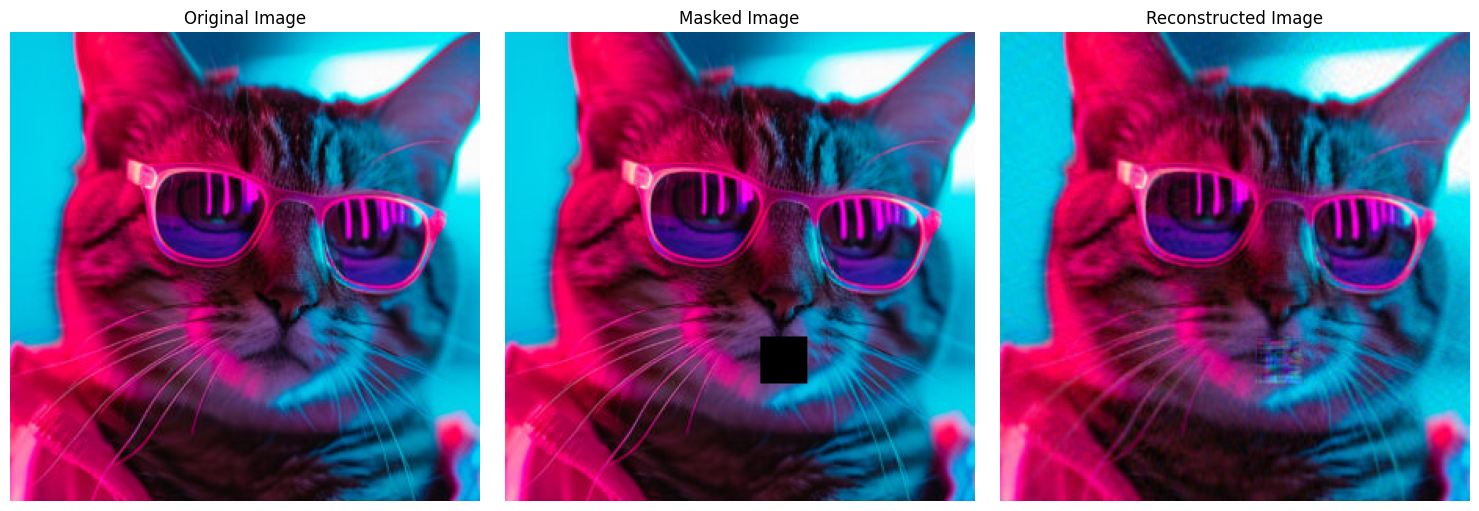

In [18]:
plot_images(crop2, masked_img2, reconstructed_img2)

In [27]:
rmse_patch, psnr_patch = calculate_metrics(normalize(crop2),normalize(reconstructed_img2))


print("The Peak signal to noise ratio is:", psnr_patch)
print("The Root mean square error is:", rmse_patch)

The Peak signal to noise ratio is: 30.11130142211914
The Root mean square error is: 0.031220147386193275


**Comparasion with the RFF features + linear regression method**

In [21]:
copy_masked_img = masked_img[0].clone()

masked_img2 = copy_masked_img

X, Y = create_coordinate_map(masked_img2)
X , scaler = scale_coordinates(X)
temp = mask_img2.reshape(-1,1)

img_scaled = masked_img2/255
original_scaled = crop2/255

filtered_X = X[~torch.any(Y.isnan(),dim=1)]
filtered_Y = Y[~torch.any(Y.isnan(),dim=1)]
filtered_Y = torch.from_numpy(preprocessing.MinMaxScaler().fit_transform(filtered_Y)).float()
print(Y)
print(Y/255)


tensor([[  1., 202., 232.],
        [  1., 202., 232.],
        [  0., 200., 228.],
        ...,
        [  0., 171., 227.],
        [  2., 159., 228.],
        [ 10., 144., 217.]])
tensor([[0.0039, 0.7922, 0.9098],
        [0.0039, 0.7922, 0.9098],
        [0.0000, 0.7843, 0.8941],
        ...,
        [0.0000, 0.6706, 0.8902],
        [0.0078, 0.6235, 0.8941],
        [0.0392, 0.5647, 0.8510]])


In [22]:
X_rff = create_rff_features(X, 20000, 0.008).to(device)
X_rff_filtered = X_rff[~torch.any(Y.isnan(),dim=1)]

In [23]:
X_rff_filtered.shape
net = LinearModel(X_rff_filtered.shape[1], 3).to(device)
train(net, 0.005, X_rff_filtered.to(device), filtered_Y.to(device), 2000)

Epoch 0 loss: 0.220997
Epoch 100 loss: 0.048961
Epoch 200 loss: 0.029444
Epoch 300 loss: 0.019410
Epoch 400 loss: 0.013179
Epoch 500 loss: 0.009149
Epoch 600 loss: 0.006487
Epoch 700 loss: 0.004710
Epoch 800 loss: 0.003514
Epoch 900 loss: 0.002705
Epoch 1000 loss: 0.002156
Epoch 1100 loss: 0.001779
Epoch 1200 loss: 0.001519
Epoch 1300 loss: 0.001335
Epoch 1400 loss: 0.001204
Epoch 1500 loss: 0.001108
Epoch 1600 loss: 0.001037
Epoch 1700 loss: 0.000983
Epoch 1800 loss: 0.000942
Epoch 1900 loss: 0.000910


0.000885619840119034

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


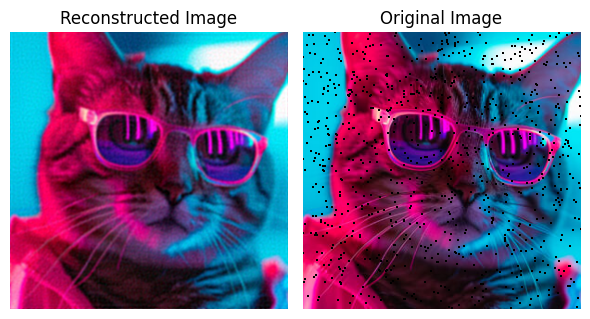

In [24]:
_ = plot_reconstructed_and_original_image(masked_img2/255, net, X_rff, title="")

In [26]:
rmse_rff, psnr_rff = calculate_metrics(_.cpu(), (original_scaled.reshape(300,300,3)))

print("The Peak signal to noise ratio is:", psnr_rff)
print("The Root mean square error is:", rmse_rff)

The Peak signal to noise ratio is: 7.315923690795898
The Root mean square error is: 0.4307287335395813
